In [53]:
import numpy as np
import pandas as pd
import os

from cell_metric import *
from model_functions import psix_score, psix_score_precomputed_smooth
from tpm_to_mrna import tpm2mrna
import anndata
# from anndata import AnnData
from smartseq_tools import *

from multiprocessing import Pool
from tqdm import tqdm
import itertools  


import warnings
warnings.filterwarnings("ignore")

# def _foo(my_number):
#    square = my_number * my_number
#    time.sleep(1)
#    return square 

# if __name__ == '__main__':
#    with Pool(2) as p:
#       r = list(tqdm.tqdm(p.imap(_foo, range(30)), total=30))

class Psix:
    
    def __init__(
        self,
        adata = anndata.AnnData(),
        reads_file = ''
    ):
        self.adata = adata
        
        if os.path.isfile(reads_file):
            self.adata = anndata.read_csv(reads_file, delimiter='\t', first_column_names=True).T
            
                
    def compute_neighbors_psi(self, latent='latent', n_neighbors=100, remove_self=True):
        if not latent in self.adata.obsm:
            try:
                latent = pd.read_csv(latent, sep='\t', index_col=0)
                self.adata.obsm['latent'] = latent
                latent = 'latent'
            except:
                raise Exception('Latent space "' + latent +'" does not exist.')
                
        get_background(self, latent, n_neighbors=n_neighbors, remove_self=remove_self)
        print('Successfully computed neighbors')
            
    def compute_psix_scores(self, latent='latent', 
                            n_jobs=1,
                           capture_efficiency = 0.1, 
                                           min_probability = 0.01,
                                           seed=0,
                                           pvals_bins=5,
                                           n_random_exons = 1000
                           ):
        
        self.capture_efficiency = capture_efficiency
        self.min_probability = min_probability
        self.seed = seed
        self.pvals_bins = pvals_bins
        self.n_random_exons = n_random_exons
        self.n_jobs = n_jobs
        
#         if not 'neighbors_psi' in self.adata.uns:
#             print('neighbors_psi does not exist, computing...')
#             self.compute_neighbors_psi(latent=latent, n_neighbors=100, remove_self=True)
            
            
#         print('Computing Psix scores...')
#         self.exon_score_array = [psix_score_precomputed_smooth(
#                                     self.adata.uns['psi'][exon], 
#                                     self.adata.uns['mrna_per_event'][exon], 
#                                     self.adata.uns['neighbors_psi'][exon], 
#                                     capture_efficiency = 0.1, 
#                                     min_probability = 0.01
#                                 ) for exon in tqdm(self.adata.uns['psi'].columns, position=0, leave=True)]
            
        
        if self.n_jobs == 1:
            exon_score_array = [psix_score(self.adata.uns['psi'][exon], 
                                           self.adata.uns['mrna_per_event'][exon], 
                                           self.adata.uns['cell_metric'], 
                                           capture_efficiency = self.capture_efficiency, 
                                           randomize = False,  
                                           min_probability = self.min_probability,
                                           seed=0
                                        ) for exon in tqdm(self.adata.uns['psi'].columns, position=0, leave=True)]
        else:
            exon_list = self.adata.uns['psi'].columns
            
            with Pool(
                processes=self.n_jobs
            ) as pool:
                
                chunksize = np.int(np.ceil(len(exon_list)/self.n_jobs))

                exon_score_array = list(
                    tqdm(
                        pool.imap(self.psix_score_parallel, exon_list, chunksize=chunksize),
                        total=len(exon_list), position=0, leave=True
                    )
                )
#              = results
        
        self.psix_results = pd.DataFrame()
        self.psix_results['psix_score'] = exon_score_array
        self.psix_results.index = exon_list
        
        print('Successfully ran Psix on exons.')
        print('...')
        print('')
        print('Estimating p-values')
        
        self.compute_pvalues()
        
    
              
    def psix_score_parallel(self, exon):
        return psix_score(self.adata.uns['psi'][exon], 
                                           self.adata.uns['mrna_per_event'][exon], 
                                           self.adata.uns['cell_metric'], 
                                           capture_efficiency = self.capture_efficiency, 
                                           randomize = False,  
                                           min_probability = self.min_probability,
                                           seed=self.seed)
        
        
            
    def get_cell_metric(self, latent='latent', n_neighbors = 100, weight_metric=True):
        
        if latent in self.adata.obsm:
            latent = self.adata.obsm[latent]
            
        else:
            try:
                latent = pd.read_csv(latent, sep='\t', index_col=0)
                self.adata.obsm['latent'] = latent
            except:
                raise Exception('Latent space "' + latent +'" does not exist.')
                
        self.adata.uns['cell_metric'] = compute_cell_metric(latent, 
                                                       n_neighbors = n_neighbors, 
                                                       weight_metric = weight_metric
                                                      )        
        
    def process_smartseq(
        self,
        exon_sj_file,
        constitutive_sj_file,
        tpm_file,
        minJR = 5,
        minCell=20,
        drop_duplicates = False,
        min_psi = 0.05,
        min_observed = 0.25
    ):
        
        print('Obtaining psi tables...')
            
        psi, reads = get_psi_table(exon_sj_file, minJR, minCell, drop_duplicates)
        
        alt_exons = psi.index[np.abs(0.5 - psi.mean(axis=1)) <= (0.5-min_psi)]
        obs_exons = psi.index[psi.isna().mean(axis=1) <= 1-min_observed]
        selected_exons = alt_exons & obs_exons
        
        psi = psi.loc[selected_exons]
        reads = reads.loc[selected_exons]
        
        print('Reading TPM and transforming to mRNA counts...')
        
        mrna = tpm2mrna(tpm_file)
        mrna_per_event = get_mrna_per_event(mrna, psi, reads, constitutive_sj_file)
        
        self.adata.uns['psi'] = psi.T
        self.adata.uns['mrna_per_event'] = mrna_per_event.T
        
        print('Successfully processed smart-seq data')
        
    def save_psix_object(self, psix_dir = 'psix_object/', overwrite = False):
        if os.path.isdir(psix_dir):
            if overwrite:
                sp.run('rm -r ' + psix_dir, shell=True)
            else:
                raise Exception('Directory ' + psix_dir +' already exists')
        else:
            self.adata.write(psix_dir)
            
    def read_psix_object(self, psix_dir = 'psix_object'):
        self.adata = anndata.read_h5ad(psix_dir)
        
    def get_bins(self):
        mrna_table = self.adata.uns['mrna_per_event']
        psi_table = self.adata.uns['psi']
        b = self.pvals_bins

        express_mean = np.log10(mrna_table+1).mean(axis=0)
        x_step = (express_mean.max() - express_mean.min())/b
        psi_var = psi_table.var(axis=0)
        p_step = (psi_var.max() - psi_var.min())/b


        bins = {}
        for i in range(b):
            mean_bins = {}

            exons_x_small = express_mean.index[express_mean >= express_mean.min() + i*x_step]
            exons_x_large = express_mean.index[express_mean <= express_mean.min() + (i+1)*x_step]
            exons_x = exons_x_small.intersection(exons_x_large)

            if i == (b-1):
                exons_x = exons_x_small

            for j in range(b):
                exons_var_small = psi_var.index[psi_var >= psi_var.min() + j*p_step]
                exons_var_large = psi_var.index[psi_var <= psi_var.min() + (j+1)*p_step]
                exons_var = exons_var_small.intersection(exons_var_large).intersection(exons_x)

                if j == (b-1):
                    exons_var = exons_var_small.intersection(exons_x)

                mean_bins.update({'var_' + str(j+1):exons_var})

            bins.update({'mean_' + str(i+1):mean_bins})

        bin_dir = pd.DataFrame()
        for mean in bins.keys():
            for var in bins[mean].keys():
                for exon in bins[mean][var]:
                    bin_dir[exon] = [mean + '_' + var]

        assert len([x for x in self.adata.uns['psi'].columns if x not in bin_dir.T.index]) == 0
        self.exon_bins = bin_dir
        self.bins = bins


    def compute_pvalues(self):
        self.get_bins()

        np.random.seed(self.seed)
        
        mean_list = ['mean_'+str(i+1) for i in range(self.pvals_bins)]
        var_list = ['var_'+str(i+1) for i in range(self.pvals_bins)]
        self.random_scores = {}
        for m in mean_list:
            m_dict = {}
            for v in var_list:
                m_dict.update({v:[]})
            self.random_scores.update({m:m_dict})

        

        
        all_buckets = list(itertools.product(mean_list, var_list))


        if self.n_jobs == 1:
            for bucket in all_buckets:
                bucket_scores = compute_random_exons(self, bucket)
                self.random_scores[bucket[0]][bucket[1]] = buckets_scores

        else:

            with Pool(
                processes=self.n_jobs
            ) as pool:

                chunksize = np.int(np.ceil((self.pvals_bins**2)/self.n_jobs))

                results = list(
                    tqdm(
                        pool.imap(self.compute_random_exons, all_buckets, chunksize=chunksize),
                        total=len(all_buckets), position=0, leave=True
                    )
                )
            self.exon_score_array = results
            
            for i in range(self.pvals_bins**2):
                bucket = all_buckets[i]
                self.random_scores[bucket[0]][bucket[1]] = list(results[i])




    def compute_random_exons(self, bucket):

        exon_list = self.bins[bucket[0]][bucket[1]]
        
#         print(exon_list)

        if len(exon_list)==0:
            return np.array([])

        else:
            r_choice = np.random.choice(exon_list, self.n_random_exons, replace=True)

            if self.n_jobs == 1:

                output = [psix_score(self.adata.uns['psi'][exon], 
                           self.adata.uns['mrna_per_event'][exon], 
                           self.adata.uns['cell_metric'], 
                           capture_efficiency = self.capture_efficiency, 
                           randomize = True,  
                           min_probability = self.min_probability,
                           seed=self.seed) for exon in tqdm(r_choice, position=0, leave=True)]
            else:
                output = [psix_score(self.adata.uns['psi'][exon], 
                           self.adata.uns['mrna_per_event'][exon], 
                           self.adata.uns['cell_metric'], 
                           capture_efficiency = self.capture_efficiency, 
                           randomize = True,  
                           min_probability = self.min_probability,
                           seed=self.seed) for exon in r_choice]
            return np.array(output)
    



In [2]:


list(itertools.product(['m1', 'm2'], ['var1', 'var2']))


[('m1', 'var1'), ('m1', 'var2'), ('m2', 'var1'), ('m2', 'var2')]

In [2]:
psix_object = Psix(reads_file='../data/mouse_brain_development/star_counts.tab.gz')

In [3]:
psix_object.process_smartseq(
        '../data/mouse_brain_development/sj_counts.tab.gz',
        '../data/mouse_brain_development/constitutive_introns.gz',
        '../data/mouse_brain_development/tpm.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.25)

Obtaining psi tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 1197/1197 [00:51<00:00, 23.05it/s]


Successfully processed smart-seq data


In [54]:
# psix_object.save_psix_object(overwrite=True)
psix_object = Psix()
psix_object.read_psix_object()

In [7]:
# psix_object.compute_psix_scores(
#     latent='/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/rd_pc2.tab'
# )

In [33]:
psix_object.get_cell_metric(latent='/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/rd_pc2.tab', 
                            n_neighbors = 100, weight_metric=True)

100%|██████████| 1197/1197 [00:24<00:00, 48.33it/s]


In [57]:
psix_object.compute_psix_scores(n_jobs=20,
#     latent='/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/rd_pc2.tab'
n_random_exons=2000)

100%|██████████| 2019/2019 [00:27<00:00, 73.48it/s] 


Successfully ran Psix on exons.
...

Estimating p-values


100%|██████████| 25/25 [16:38<00:00, 39.95s/it]  


In [56]:
psix_object.random_scores#['mean_1']['var_1'] += np.array([0, 0, 0])

{'mean_1': {'var_1': [-0.03567848491704345, -0.0020147292703918537],
  'var_2': [-0.002155034092668414, 0.0018415928852454522],
  'var_3': [-0.011436889245218605, -0.0014588133454506783],
  'var_4': [-0.04328629367610936, 0.02083058855520748],
  'var_5': [-0.0039884767568729015, -0.03720822385110203]},
 'mean_2': {'var_1': [-0.0014139519378345898, -0.020115671416799135],
  'var_2': [-0.007701889165386478, -0.010160895974601852],
  'var_3': [-0.011927886550493606, -0.015007947978437401],
  'var_4': [-0.011058529268997778, 0.006847278412903322],
  'var_5': [-0.03181697166719158, -0.019704193332179556]},
 'mean_3': {'var_1': [-0.0029542108532821386, 0.004374348680836805],
  'var_2': [0.0017254112571949017, -0.010481205607202644],
  'var_3': [-0.0006888211362528716, -0.005822671662050352],
  'var_4': [],
  'var_5': []},
 'mean_4': {'var_1': [-0.0009577550938819501, 0.05360981891205964],
  'var_2': [0.026712143612146796, 0.01601675253653473],
  'var_3': [0.008515443384136036, 0.008515443384

In [5]:
psix_object.adata.uns['cell_metric']

,SRR7408400,SRR7408401,SRR7408404,SRR7408413,SRR7408414,SRR7408418,SRR7408422,SRR7408424,SRR7408426,SRR7408427,...,SRR7410086,SRR7410088,SRR7410089,SRR7410090,SRR7410091,SRR7410092,SRR7410093,SRR7410094,SRR7410096,SRR7410097
SRR7408400,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.789344,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
SRR7408401,0.0,0.000000,0.890614,0.813859,0.000000,0.0,0.774217,0.000000,0.457103,0.905425,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
SRR7408404,0.0,0.918609,0.000000,0.878344,0.644366,0.0,0.606575,0.000000,0.000000,0.871803,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
SRR7408413,0.0,0.808382,0.832926,0.000000,0.622730,0.0,0.608901,0.000000,0.000000,0.573475,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
SRR7408414,0.0,0.577633,0.736445,0.791407,0.000000,0.0,0.383765,0.000000,0.000000,0.475570,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7410092,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.690354,0.000000,0.000000,0.000000,0.0,0.77034,0.000000,0.000000
SRR7410093,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.721630,0.0,0.000000,0.480489,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
SRR7410094,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.555318,0.000000,0.367879,0.646722,0.0,0.00000,0.000000,0.423467
SRR7410096,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.590787,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.552598


In [10]:
def get_background(psi_table, W, exon_list):
    
    psi_output = pd.DataFrame()
    
    for exon in tqdm(exon_list):

        exon_psi = psi_table.loc[exon]
        
        blanco = np.array([0 if np.isnan(x) else 1 for x in np.array(exon_psi)])
        
        background_psi = np.array((W*exon_psi).sum(axis=1))/np.array(W*blanco).sum(axis=1)
        
        psi_output[exon] = background_psi
    
    psi_output.index = psi_table.columns
    return psi_output.T

In [15]:
bg = get_background(psix_object.adata.uns['psi'].T, psix_object.adata.uns['cell_metric'], ['Mapt_1', 'Cadm1_10'])

100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


In [21]:
W = psix_object.adata.uns['cell_metric']
pslice = psix_object.adata.uns['psi'].T.loc[['Mapt_1', 'Cadm1_10']]

In [33]:
blank = (~pslice.isna()).astype(int)

In [62]:
W.multiply(pslice.loc[['Mapt_1', 'Cadm1_10']].T, axis=0)

,Cadm1_10,Mapt_1,SRR7408400,SRR7408401,SRR7408404,SRR7408413,SRR7408414,SRR7408418,SRR7408422,SRR7408424,...,SRR7410086,SRR7410088,SRR7410089,SRR7410090,SRR7410091,SRR7410092,SRR7410093,SRR7410094,SRR7410096,SRR7410097
SRR7408400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR7408401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR7408404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR7408413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR7408414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7410092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR7410093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR7410094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR7410096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
(np.matrix(W)*np.matrix(blank).T).sum(axis=0)

matrix([[75195.83782767, 71422.53709946]])

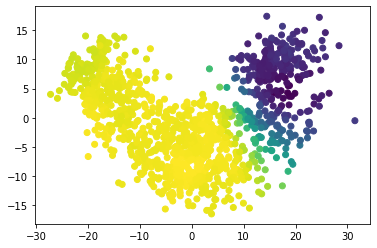

In [18]:
from matplotlib import pyplot as plt
plt.scatter(psix_object.adata.obsm['latent'].PC_1, psix_object.adata.obsm['latent'].PC_2, c=bg.loc['Cadm1_10'])

In [5]:
psix_object.compute_psix_scores()

 12%|█▏        | 236/2019 [00:28<02:49, 10.55it/s]/mnt/lareaulab/cfbuenabadn/psix/psix/model_functions.py:53: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
/mnt/lareaulab/cfbuenabadn/psix/psix/model_functions.py:53: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 24%|██▍       | 489/2019 [01:01<02:14, 11.41it/s]/mnt/lareaulab/cfbuenabadn/psix/psix/model_functions.py:153: RuntimeWarning: invalid value encountered in true_divide
  )/np.array(cell_metric.loc[cell_list, cell_list].sum(axis=1)))
100%|██████████| 2019/2019 [04:05<00:00,  8.22it/s]


In [61]:
tiklova_psix = pd.read_csv('~/analysis_psix/mouse_brain_development/psix/pc2.scores.txt', sep='\t', index_col=0)

In [62]:
[x for x in tiklova_psix.index if x not in psix_object.adata.uns['psi'].columns]

['Nadk_4',
 'Ddr1_2',
 'Gtf2i_1',
 'Lmbr1_10',
 'Polrmt_nmdSE_1',
 'Shtn1_1',
 'Hnrnpf_3',
 'Ube2i_4',
 'Kctd17_nmdSE_1',
 'Smim20_nmdSE_2',
 'Ablim1_6',
 'Dync1i2_4']

In [58]:
df = pd.DataFrame()
df['psix'] = psix_object.exon_score_array
df.index = psix_object.adata.uns['psi'].columns

In [70]:
df.sort_values('psix')

,psix
Acin1_7,-0.074094
Ercc8_5,-0.070889
Slc37a3_7,-0.069589
Tmem80_3,-0.068808
Mettl5_1,-0.065259
...,...
Gabrg2_1,1.572387
Mapt_3,1.629782
Dbn1_1,1.925831
Ndrg4_1,2.067698


In [63]:
psix_object.exon_score_array

[0.0001278147857756924,
 0.006550293005683117,
 -0.00010237401089431081,
 0.015323553066625308,
 0.044115405726264045,
 -0.0007801619967155751,
 0.015670570860034157,
 -0.00629277551448442,
 0.009870289941293962,
 0.01472607929165469,
 -0.027165431177742918,
 0.19572648653634878,
 -0.016733291929170568,
 -0.009659720508342547,
 0.7750295439984128,
 0.8763391231444739,
 -0.03992057446445844,
 -0.020513810763337737,
 0.06987430092721421,
 -0.01709901206709547,
 -0.0057130022199287055,
 -0.014735585222863593,
 0.015832597482140123,
 -0.07409361784047046,
 0.021724487214429763,
 0.12046749702601564,
 0.005992100595214626,
 -0.012260405516766184,
 0.026705657170898837,
 0.000765523520540048,
 0.03423459186001137,
 -0.0040387817929248525,
 0.02115147594250305,
 0.07414468080208599,
 0.08438614340610952,
 0.21342867327465967,
 0.19320103360583835,
 0.054147367326812995,
 0.023759363906832965,
 0.030828437629613847,
 0.018151879138677707,
 0.08627191557363804,
 0.2472591086695167,
 -0.03765327

In [64]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr

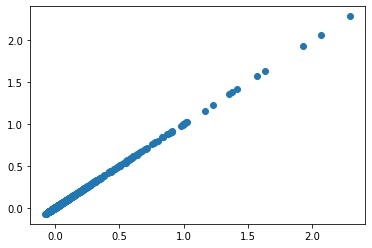

In [65]:
plt.scatter(df.psix.loc[df.index & tiklova_psix.index], tiklova_psix.loc[df.index & tiklova_psix.index].L_score)

In [66]:
pearsonr(df.psix.loc[df.index & tiklova_psix.index], tiklova_psix.loc[df.index & tiklova_psix.index].L_score)

(0.9999773959730991, 0.0)

In [67]:
spearmanr(df.psix.loc[df.index & tiklova_psix.index], tiklova_psix.loc[df.index & tiklova_psix.index].L_score)

SpearmanrResult(correlation=0.99956585186157, pvalue=0.0)

In [24]:
se_exons = pd.read_csv('~/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/skipped_exons_psi.tab',
                      sep='\t', index_col=0)

In [25]:
mrna_events = pd.read_csv('~/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/mrna_per_event.tab',
                      sep='\t', index_col=0)

In [53]:
shared = psix_object.adata.uns['psi'].columns & se_exons.index
(se_exons.T.loc[psix_object.adata.uns['psi'].index, shared] - psix_object.adata.uns['psi'][shared]).abs().sum().sum()

8.796097530905378e-13

In [29]:
shared = psix_object.adata.uns['mrna_per_event'].columns & se_exons.index
(mrna_events.T.loc[psix_object.adata.uns['mrna_per_event'].index, shared] - psix_object.adata.uns['mrna_per_event'][shared]).abs().mean().mean()

0.01683056281720648

In [30]:
mrna_events.T.loc[psix_object.adata.uns['mrna_per_event'].index, shared]

,AW554918_2,Aaed1_1,Aak1_2,Aak1_5,Aamdc_10,Aamdc_9,Aamdc_nmdSE_2,Aars2_2,Aasdhppt_2,Abat_3,...,Zmynd11_7,Zmynd8_6,Zmynd8_8,Znhit1_1,Zscan18_1,Zyx_1,Zyx_2,Zzz3_10,Zzz3_11,Zzz3_12
SRR7408400,0.917420,NaN,NaN,NaN,3.669681,0.917420,1.834840,NaN,NaN,NaN,...,2.752261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR7408401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.228644,NaN,...,NaN,3.171483,NaN,NaN,NaN,0.528581,NaN,NaN,NaN,NaN
SRR7408404,NaN,NaN,NaN,NaN,1.617931,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.831379,4.044827,NaN,NaN,0.808965,NaN,1.213448,0.404483
SRR7408413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.183354,NaN,...,NaN,NaN,NaN,2.366708,NaN,NaN,NaN,NaN,NaN,NaN
SRR7408414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.199988,0.639998,1.279995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7410092,NaN,NaN,1.492173,1.11913,2.984346,3.357389,2.238259,NaN,4.849562,11.564340,...,2.611303,3.730432,NaN,12.683470,0.373043,0.746086,0.373043,NaN,NaN,NaN
SRR7410093,NaN,NaN,NaN,NaN,5.895941,1.310209,NaN,NaN,7.206150,0.655105,...,NaN,NaN,NaN,NaN,4.585732,1.310209,1.310209,NaN,NaN,NaN
SRR7410094,NaN,0.398425,0.796850,NaN,2.390550,1.195275,0.796850,NaN,0.796850,0.398425,...,2.390550,NaN,NaN,4.781101,0.398425,NaN,NaN,NaN,0.796850,NaN
SRR7410096,NaN,1.625401,NaN,NaN,13.815908,9.752406,3.250802,3.250802,0.812700,4.063502,...,1.625401,NaN,NaN,3.250802,1.625401,NaN,NaN,NaN,NaN,NaN


In [31]:
psix_object.adata.uns['mrna_per_event'][shared]

,AW554918_2,Aaed1_1,Aak1_2,Aak1_5,Aamdc_10,Aamdc_9,Aamdc_nmdSE_2,Aars2_2,Aasdhppt_2,Abat_3,...,Zmynd11_7,Zmynd8_6,Zmynd8_8,Znhit1_1,Zscan18_1,Zyx_1,Zyx_2,Zzz3_10,Zzz3_11,Zzz3_12
SRR7408400,0.916748,NaN,NaN,NaN,3.666991,0.916748,1.833496,NaN,NaN,NaN,...,2.750243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR7408401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.197112,NaN,...,NaN,3.147834,NaN,NaN,NaN,0.524639,NaN,NaN,NaN,NaN
SRR7408404,NaN,NaN,NaN,NaN,1.614259,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.824954,4.035648,NaN,NaN,0.807130,NaN,1.210694,0.403565
SRR7408413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.176053,NaN,...,NaN,NaN,NaN,2.352106,NaN,NaN,NaN,NaN,NaN,NaN
SRR7408414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.213076,0.642615,1.285230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7410092,NaN,NaN,1.479068,1.109301,2.958137,3.327904,2.218602,NaN,4.806972,11.462780,...,2.588370,3.697671,NaN,12.572081,0.369767,0.739534,0.369767,NaN,NaN,NaN
SRR7410093,NaN,NaN,NaN,NaN,5.825304,1.294512,NaN,NaN,7.119816,0.647256,...,NaN,NaN,NaN,NaN,4.530792,1.294512,1.294512,NaN,NaN,NaN
SRR7410094,NaN,0.396928,0.793856,NaN,2.381569,1.190784,0.793856,NaN,0.793856,0.396928,...,2.381569,NaN,NaN,4.763138,0.396928,NaN,NaN,NaN,0.793856,NaN
SRR7410096,NaN,1.613623,NaN,NaN,13.715795,9.681738,3.227246,3.227246,0.806811,4.034057,...,1.613623,NaN,NaN,3.227246,1.613623,NaN,NaN,NaN,NaN,NaN


In [64]:
from sklearn.neighbors import NearestNeighbors

def compute_cell_metric(
    manifold, 
    n_neighbors=100, 
    weight_metric = True
):
    
    """
    Computes cell-cell metric from low-dimensional manifold.
    
    input:
    
        manifold: a pandas dataframe with a N-dimensional manifold. E.g., a PCA projection, or an scVI space.
                  Shape = (cells, dimensions).
                  
        n_neighbors: number of neighbors per neighborhood. It's recommended to be larger than those
                     normally used for gene expression analysis.
                     
        weight_metric: Wether if the influence of neighbours should be weighted by their proximity.
                       Similar as the weighted metric from VISION.If false, all neighbors have the 
                       same influence.
                       Non-neighbors always have 0 weight.
                   
    output: 
    
        cell_metric: a dataframe structure of (cells, cells) dimensions with the weights of
                     each neighbor.
    """
    
    cells = manifold.index
    n_cells = len(cells)
    
    knn_neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(manifold)
    distances, indices = knn_neighbors.kneighbors(manifold)
    
    cell_metric = pd.DataFrame(np.zeros((n_cells, n_cells)))
    cell_metric.columns = cells
    cell_metric.index = cells
    
    if weight_metric:
        
        for i in tqdm(range(n_cells)):
            cell_i = cells[i]
            sigma = np.max(distances[i])
            for j in range(1, len(distances[i])):
                cell_j = cells[indices[i][j]]
                d = distances[i][j]
                w = np.exp(-(d**2)/(sigma**2))        
                cell_metric.loc[cell_i, cell_j] = w
                
    else:
        for i in tqdm(range(n_cells)):
            cell_i = cells[i]
            for j in range(1, len(distances[i])):
                cell_j = cells[indices[i][j]]     
                cell_metric.loc[cell_i, cell_j] = 1
    
    return cell_metric

In [66]:
psix_object.adata.obsm['latent']

,PC_1,PC_2
SRR7408400,-11.037606,7.275128
SRR7408401,-22.010343,9.250216
SRR7408404,-23.795626,8.607317
SRR7408413,-22.368899,6.745590
SRR7408414,-25.504338,4.642485
...,...,...
SRR7410092,17.474620,-3.979515
SRR7410093,19.761627,9.867867
SRR7410094,15.408170,-0.716363
SRR7410096,14.511204,7.364319


In [315]:
def get_background(psi, manifold, exon_list, n_neighbors=100, remove_self=True):
    
    n_exons = len(exon_list)
    n_cells = len(psi.index)
    
    knn_neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(manifold)
    distances, indices = knn_neighbors.kneighbors(manifold)
    
    if remove_self:
        distances = distances[:,1:]
        indices = indices[:,1:]

    sigma_array = np.max(distances, axis=1)
    
    weights = np.exp(-(distances**2)/(sigma_array**2).reshape(len(psi.index),1))
    
    smooth_psi = pd.DataFrame()
    
    
#     t = time()
    pandas_slices = []
    for idx in indices:
        pandas_slices.append(psi[exon_list].iloc[idx].to_numpy())

    pandas_slices = np.array(pandas_slices)#.reshape(n_exons, n_cells, n_neighbors-1)
#     return pandas_slices
    
#     print('slicing time')
#     print(time()-t)
    
    
#     return pandas_slices
        
        
#         .iloc[indices[0]]['Mapt_1'].to_numpy()
        

    for i in tqdm(range(len(exon_list))):
        exon = exon_list[i]
#         print(exon)
#         t = time()
        
        neighbors_psi = pandas_slices[:,:,i]
        
# #         exon_psi = psi[exon]
#         neighbors_psi = np.array([np.array(panda[exon]) for panda in pandas_slices])
# #         neighbors_psi = np.array([exon_psi.iloc[idx].to_numpy() for idx in indices])

#         print(time()-t)


#         t = time()
        background = np.nansum(neighbors_psi*weights, axis=1)/((~np.isnan(np.array(neighbors_psi)))*weights).sum(axis=1)
#         print(time()-t)

#         print('####')
#         print('')

        smooth_psi[exon] = background

    smooth_psi.index = psi.index
    return smooth_psi.T
    

# knn_neighbors = NearestNeighbors(n_neighbors=100).fit(psix_object.adata.obsm['latent'])
# distances, indices = knn_neighbors.kneighbors(psix_object.adata.obsm['latent'])

In [316]:
from time import time

In [317]:
smooth_psi = get_background(psix_object.adata.uns['psi'], psix_object.adata.obsm['latent'],# ['Mapt_1', 'Cadm1_10'])
                            psix_object.adata.uns['psi'].columns)

100%|██████████| 3699/3699 [00:10<00:00, 367.64it/s]


In [314]:
smooth_psi#.loc['Mapt_1']

,SRR7408400,SRR7408401,SRR7408404,SRR7408413,SRR7408414,SRR7408418,SRR7408422,SRR7408424,SRR7408426,SRR7408427,...,SRR7410086,SRR7410088,SRR7410089,SRR7410090,SRR7410091,SRR7410092,SRR7410093,SRR7410094,SRR7410096,SRR7410097
AI314180_4,0.456456,0.725307,0.672624,0.691368,0.532442,0.874985,0.842177,0.669595,0.898306,0.670826,...,0.708863,0.599257,0.534444,0.624608,0.703388,0.529921,0.676044,0.493181,0.623402,0.593763
AI314180_5,0.476511,0.786964,0.756364,0.732890,0.678981,0.810421,0.817762,0.462204,0.845608,0.851888,...,0.486513,0.658196,0.519576,0.450620,0.486629,0.565528,0.418933,0.503890,0.417764,0.448342
AW554918_2,1.000000,0.682766,0.636851,0.656018,0.666354,0.654190,0.735695,1.000000,0.539562,0.665638,...,0.746847,0.388447,0.832759,0.730517,0.820412,0.807737,0.687293,0.730540,0.790019,0.972366
Aaed1_1,0.784081,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.762284,1.000000,1.000000,...,0.695189,0.748108,0.717609,0.829259,0.647907,0.714242,0.807180,0.691875,0.639710,0.643410
Aak1_2,0.837491,0.571799,0.546256,0.585726,0.616140,0.754928,0.545924,0.843203,0.726797,0.619533,...,0.932171,0.906369,0.915478,0.912033,0.896116,0.923758,0.890097,0.971673,1.000000,0.968784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zzz3_12,0.825231,0.740566,0.648881,0.755133,0.627682,0.858218,0.770209,0.808764,0.837072,0.788601,...,1.000000,1.000000,0.804606,1.000000,0.896044,0.643607,1.000000,0.806828,0.926921,0.869943
l7Rn6_1,0.781136,0.827904,0.789529,0.791589,0.772439,0.719682,0.790914,0.801366,0.733777,0.791018,...,0.918150,0.827187,0.900598,0.934568,0.920392,0.885888,0.927270,0.875161,0.937227,0.920347
l7Rn6_3,0.027866,0.014276,0.013216,0.014195,0.031747,0.062855,0.029702,0.025940,0.056418,0.029585,...,0.085383,0.088484,0.053858,0.091383,0.065681,0.061758,0.063291,0.045945,0.094131,0.046239
l7Rn6_4,0.068945,0.072730,0.055657,0.101351,0.094518,0.078944,0.099026,0.133989,0.081742,0.078667,...,0.476480,0.116604,0.275303,0.526799,0.335623,0.319787,0.510454,0.251989,0.518072,0.325747


In [312]:
spearmanr(bg.loc['Mapt_1'], smooth_psi.loc['Mapt_1'])

SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)

In [271]:
smooth_psi.reshape(3699, 1197, 99)[0]

array([[nan, nan, nan, ..., nan, nan,  1.],
       [nan, nan,  0., ..., nan,  1.,  1.],
       [ 1., nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  0.,  1., ..., nan, nan, nan],
       [nan, nan,  1., ...,  1.,  1., nan]])

In [ ]:
panda_slices = []
panda_slices.append(psix_object.adata.uns['psi'].iloc[indices[0]])
panda_slices.append(psix_object.adata.uns['psi'].iloc[indices[1]])

In [242]:
psix_object.adata.uns['psi'].iloc[indices[0]]['Mapt_1'].to_numpy()

array([0.        , 0.        , 0.056     , 0.02762431, 0.        ,
       0.        , 0.17142857, 0.04615385, 0.        , 0.05172414,
       0.        , 0.        , 0.15315315, 0.        , 0.05660377,
       0.        , 0.        ,        nan, 0.        , 0.        ,
       0.06918239, 0.        ,        nan, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16129032, 0.0964467 , 0.25      , 0.        ,
       0.        , 0.        , 0.        , 0.16666667, 0.01149425,
       0.        , 0.12643678, 0.        , 0.        , 0.0755287 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0052356 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.19327731, 0.1030303 , 0.12      , 0.        ,
       0.        , 0.14285714, 0.        , 0.08597285, 0.     

In [ ]:
get_background(psi, manifold, exon_list, n_neighbors=100, remove_self=True)

In [108]:
distancias = distances[:,1:]
indicios = indices[:,1:]

In [109]:
sigma_array = np.max(distancias, axis=1)

In [202]:
panda_slices

[            AI314180_4  AI314180_5  AW554918_2  Aaed1_1  Aak1_2  Aak1_5  \
 SRR7408400         NaN         NaN         1.0      NaN     NaN     NaN   
 SRR7408587         NaN         NaN         NaN      NaN     NaN     NaN   
 SRR7408553         NaN         NaN         NaN      NaN     NaN     NaN   
 SRR7408521         NaN         NaN         NaN      NaN     NaN     NaN   
 SRR7408697         NaN         NaN         NaN      NaN     NaN     NaN   
 ...                ...         ...         ...      ...     ...     ...   
 SRR7408519         NaN         NaN         NaN      1.0     NaN     NaN   
 SRR7408603         NaN         0.0         NaN      NaN     NaN     NaN   
 SRR7408720         NaN         NaN         NaN      NaN     NaN     NaN   
 SRR7408654         NaN         0.0         NaN      NaN     NaN     NaN   
 SRR7408858         NaN         NaN         NaN      NaN     NaN     NaN   
 
             Aamdc_10  Aamdc_9  Aamdc_nmdSE_2  Aars2_2  ...  Zufsp_1  Zyx_1  \
 SRR740

In [86]:
distances

array([[0.        , 0.76152728, 0.85044752, ..., 6.15250842, 6.18303174,
        6.23170006],
       [0.        , 0.54657226, 0.55909755, ..., 5.46128832, 5.51296541,
        5.57503851],
       [0.        , 0.13511762, 0.66635021, ..., 6.40218869, 6.44440971,
        6.51244819],
       ...,
       [0.        , 0.38299095, 0.7856818 , ..., 5.79541802, 5.83126532,
        5.85056904],
       [0.        , 0.25622916, 0.31419253, ..., 4.16972121, 4.18303987,
        4.18934075],
       [0.        , 0.44852685, 0.5977029 , ..., 4.83855419, 4.8547895 ,
        4.86794031]])

In [117]:
weights = np.exp(-(distancias**2)/(sigma_array**2).reshape(1197,1))

In [114]:
indicios

array([[ 102,   71,   39, ...,  231,  166,  360],
       [  27,  104,   11, ...,   52,  326,   28],
       [  55,  137,   82, ...,  143,   62,   80],
       ...,
       [1077, 1040,  918, ..., 1179,  476, 1191],
       [1158,  990,  916, ..., 1174, 1000,  931],
       [1053,  925, 1165, ...,  940,  911, 1131]])

In [121]:
weights

array([[0.98517758, 0.98154798, 0.98125907, ..., 0.37728827, 0.37364789,
        0.36787944],
       [0.99043436, 0.98999315, 0.98571751, ..., 0.3830425 , 0.37611672,
        0.36787944],
       [0.99956963, 0.98958534, 0.97871381, ..., 0.3804405 , 0.37560612,
        0.36787944],
       ...,
       [0.99572387, 0.98212743, 0.9819596 , ..., 0.37484763, 0.37031104,
        0.36787944],
       [0.99626618, 0.99439108, 0.98437524, ..., 0.3713332 , 0.36898687,
        0.36787944],
       [0.99154635, 0.98503728, 0.96781666, ..., 0.37233432, 0.36986978,
        0.36787944]])

In [156]:
neighborhood_psi = []
for idx in indicios:
    neighborhood_psi.append(pslice.loc['Mapt_1'].iloc[idx])
    
neighborhood_psi = np.array(neighborhood_psi)
    
neighbor_psi = pslice.loc['Mapt_1'].iloc[indicios[0]]


In [172]:
aver = np.nansum(neighborhood_psi*weights, axis=1)/((~np.isnan(np.array(neighborhood_psi)))*weights).sum(axis=1)

In [174]:
from scipy.stats import pearsonr, spearmanr
pearsonr(aver, bg.loc['Mapt_1'])

(0.9999999999999998, 0.0)

In [175]:
spearmanr(aver, bg.loc['Mapt_1'])

SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)

In [169]:
((~np.isnan(np.array(neighborhood_psi)))*weights).sum(axis=1)

array([59.92559936, 65.85239924, 62.44553926, ..., 66.09755425,
       64.89190203, 59.07790762])

In [154]:
np.nansum(np.array(neighbor_psi)*(weights[0]))/np.nansum((~np.isnan(np.array(neighbor_psi)))* weights[0])

0.034451410073918054

In [159]:
np.array(neighbor_psi)*(weights[0])

array([0.        , 0.05496669, 0.0271066 , 0.        , 0.        ,
       0.16377278, 0.04361999, 0.        , 0.04565935, 0.        ,
       0.        , 0.13057077, 0.        , 0.04788951, 0.        ,
       0.        ,        nan, 0.        , 0.        , 0.05418567,
       0.        ,        nan, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11819008, 0.06955669, 0.17932076, 0.        , 0.        ,
       0.        , 0.        , 0.11662335, 0.00803925, 0.        ,
       0.08462717, 0.        , 0.        , 0.04929602, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00290614, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09388983, 0.04994003, 0.05805167, 0.        , 0.        ,
       0.06759442, 0.        , 0.04051986, 0.        , 0.     

In [155]:
bg

,SRR7408400,SRR7408401,SRR7408404,SRR7408413,SRR7408414,SRR7408418,SRR7408422,SRR7408424,SRR7408426,SRR7408427,...,SRR7410086,SRR7410088,SRR7410089,SRR7410090,SRR7410091,SRR7410092,SRR7410093,SRR7410094,SRR7410096,SRR7410097
Mapt_1,0.034451,0.042707,0.037484,0.032414,0.034315,0.054123,0.042860,0.027626,0.053022,0.046680,...,0.990314,0.112914,0.912751,0.992160,0.983991,0.745144,0.992708,0.805902,0.975978,0.982397
Cadm1_10,0.968377,0.942588,0.948420,0.951940,0.957055,0.956907,0.947883,0.973278,0.956334,0.946892,...,0.492955,0.976630,0.528537,0.514579,0.431871,0.656001,0.496931,0.575007,0.477465,0.459199


In [152]:
(~np.isnan(np.array(neighbor_psi)))* weights[0]

array([0.98517758, 0.98154798, 0.98125907, 0.9757063 , 0.96222763,
       0.95534124, 0.94509972, 0.92349094, 0.88274748, 0.85592536,
       0.85434735, 0.85255033, 0.85126409, 0.84604798, 0.84424445,
       0.82995102, 0.        , 0.81036251, 0.78934351, 0.78322919,
       0.78262404, 0.        , 0.77675504, 0.77233756, 0.7658645 ,
       0.76177661, 0.7410452 , 0.74102937, 0.74067597, 0.73975365,
       0.73277849, 0.72119301, 0.71728305, 0.71681815, 0.71670081,
       0.7119283 , 0.70917466, 0.69974009, 0.6994148 , 0.67365494,
       0.669324  , 0.66202094, 0.66070794, 0.65267935, 0.64361785,
       0.64239082, 0.63071956, 0.62674446, 0.62006747, 0.61593676,
       0.61121839, 0.60440307, 0.59913636, 0.59661582, 0.58599525,
       0.57443968, 0.55507266, 0.55333936, 0.52968892, 0.52352146,
       0.51978465, 0.51452376, 0.50919187, 0.49311546, 0.48596419,
       0.48577782, 0.48471203, 0.48376395, 0.48362347, 0.47621294,
       0.47316097, 0.47216426, 0.47131   , 0.47072358, 0.46339

In [ ]:
def get_background_psi_speed(psi_table, neighbors, weights, exon):
    

In [80]:
sigma_array**2

array([4.84323576, 1.98882275, 2.95296367, ..., 1.95616852, 1.22730726,
       3.24417027])

In [ ]:
sigma = np.max(distances[i])
            for j in range(1, len(distances[i])):
                cell_j = cells[indices[i][j]]
                d = distances[i][j]
                w = np.exp(-(d**2)/(sigma**2))        
                cell_metric.loc[cell_i, cell_j] = w